In [2]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
from matplotlib import pyplot as plt

import argparse
import datetime
import json
import random
import time
from pathlib import Path
import os

import numpy as np
import pandas as pd 
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model
from PIL import Image, ImageFilter

from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)

from tqdm import tqdm

from utils import *
#from datasets.loaddata_g import *
from dataset_algonauts import fetch_dataloader

from scipy.stats import pearsonr as corr

import code

## testing a model checkpooint

In [1]:
import ast
import pprint


class param2args(object):
    def __init__(self, my_dict):
        for key in my_dict:
            setattr(self, key, my_dict[key])

def parse_params(param_filename):
    file = open(param_filename, "r")
    contents = file.read()
    params = ast.literal_eval(contents)
    file.close()
    args = param2args(params)
    return args 


# [{0: 'Unknown',
#   1: 'V1v',
#   2: 'V1d',
#   3: 'V2v',
#   4: 'V2d',
#   5: 'V3v',
#   6: 'V3d',
#   7: 'hV4'},
#  {0: 'Unknown', 1: 'EBA', 2: 'FBA-1', 3: 'FBA-2', 4: 'mTL-bodies'},
#  {0: 'Unknown',
#   1: 'OFA',
#   2: 'FFA-1',
#   3: 'FFA-2',
#   4: 'mTL-faces',
#   5: 'aTL-faces'},
#  {0: 'Unknown', 1: 'OPA', 2: 'PPA', 3: 'RSC'},
#  {0: 'Unknown',
#   1: 'OWFA',
#   2: 'VWFA-1',
#   3: 'VWFA-2',
#   4: 'mfs-words',
#   5: 'mTL-words'},
#  {0: 'Unknown',
#   1: 'early',
#   2: 'midventral',
#   3: 'midlateral',
#   4: 'midparietal',
#   5: 'ventral',
#   6: 'lateral',
#   7: 'parietal'}]

roi_name_ind = 2
lay = 1
run = 23

readout_res_all = ['visuals','bodies','faces','places','words','streams_inc']

readout_res = readout_res_all[roi_name_ind]

load_model_path = '../results_ood/detr_dino_' + str(lay) + '_' + readout_res + '_16/01/run' + str(run)+ '/'
params_filename = load_model_path + '/params.txt'

args = parse_params(params_filename)
pprint.pprint(args.__dict__, sort_dicts=False)

{'lr': 0.0001,
 'lr_backbone': 1e-05,
 'batch_size': 32,
 'weight_decay': 0.0001,
 'epochs': 15,
 'lr_drop': 200,
 'clip_max_norm': 0.1,
 'subj': '01',
 'run': 23,
 'data_dir': '../../algonauts_2023_challenge_data/subj01',
 'parent_submission_dir': './algonauts_2023_challenge_submission/',
 'saved_feats': None,
 'saved_feats_dir': '../../algonauts_image_features/',
 'decoder_arch': 'transformer',
 'readout_res': 'faces',
 'resume': None,
 'frozen_weights': None,
 'pretrained': '../../pretrained/detr_r50.pth',
 'frozen_params': 'backbone input_proj',
 'backbone': 'dinov2',
 'dilation': False,
 'position_embedding': 'sine',
 'enc_layers': 0,
 'dec_layers': 1,
 'dim_feedforward': 2048,
 'hidden_dim': 768,
 'dropout': 0.1,
 'nheads': 16,
 'num_queries': 16,
 'pre_norm': False,
 'enc_output_layer': 1,
 'output_layer': 'backbone',
 'masks': False,
 'aux_loss': False,
 'set_cost_class': 1,
 'set_cost_bbox': 1,
 'set_cost_giou': 2,
 'mask_loss_coef': 1,
 'dice_loss_coef': 1,
 'bbox_loss_coef':

In [3]:
args.resume = load_model_path + 'checkpoint_.pth'

device = args.device

args.batch_size = 32

model, criterion = build_model(args)
model.to(device)

checkpoint = torch.load(args.resume, map_location='cpu')

pretrained_dict = checkpoint['model']
model.load_state_dict(pretrained_dict)

model.eval()

Using cache found in /home/ha2366/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available
/engram/nklab/algonauts/detr_base_algo/main/models/detr.py:512: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/torch/csrc/utils/tensor_new.cpp:245.)
  self.lh_challenge_rois = torch.tensor(lh_challenge_rois).to(args.device)


DETR(
  (transformer): Transformer(
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3)

In [4]:
# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))
    
    
lh_rois = torch.tensor(lh_challenge_rois[args.rois_ind]).to(args.device)  # -1
rh_rois = torch.tensor(rh_challenge_rois[args.rois_ind]).to(args.device)  # -1

lh_challenge_rois_s = []
rh_challenge_rois_s = []
for i in range(args.roi_nums):
    lh_challenge_rois_s.append(torch.where(lh_rois == i, 1, 0))
    rh_challenge_rois_s.append(torch.where(rh_rois == i, 1, 0))

lh_challenge_rois_s = torch.vstack(lh_challenge_rois_s)
rh_challenge_rois_s = torch.vstack(rh_challenge_rois_s)


In [9]:

# train_dataloader, val_dataloader = fetch_dataloader(args, args.batch_size, train='train', shuffle=False)
# test_dataloader = fetch_dataloader(args, args.batch_size, train='test')
# args.run
#samples, lh_f, rh_f = next(iter(train_dataloader))


import torchvision.transforms as T
preprocess = T.Compose([
             T.ToTensor(),
             T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])


train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
image_path = train_img_dir + '/train-9039_nsd-66847.png'
image = Image.open(image_path)

img = preprocess(image)

patch_size = 14

size_im = (
    img.shape[0],
    int(np.ceil(img.shape[1] / patch_size) * patch_size),
    int(np.ceil(img.shape[2] / patch_size) * patch_size),
)
paded = torch.zeros(size_im)
paded[:, : img.shape[1], : img.shape[2]] = img
img = paded

img = img[None, :,:,:]
img.shape

torch.Size([1, 3, 434, 434])

In [10]:

conv_features, enc_output, enc_attn_weights, dec_attn_weights = [], [], [], []

hooks = [
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]


samples = tuple(img.to(device))
samples = nested_tensor_from_tensor_list(samples)

#targets =  {'lh_f':lh_f.to(device), 'rh_f':rh_f.to(device)}

outputs = model(samples)


# lh_f = targets['lh_f']
# rh_f = targets['rh_f']


lh_f_pred = outputs['lh_f_pred'][:,:,:args.roi_nums]
rh_f_pred = outputs['rh_f_pred'][:,:,:args.roi_nums]

if args.readout_res != 'hemis':

    lh_challenge_rois_b = torch.tile(lh_challenge_rois_s[:,:,None], (1,1,lh_f_pred.shape[0])).permute(2,1,0)
    rh_challenge_rois_b = torch.tile(rh_challenge_rois_s[:,:,None], (1,1,rh_f_pred.shape[0])).permute(2,1,0)

    lh_f_pred = torch.sum(torch.mul(lh_challenge_rois_b, lh_f_pred), dim=2)
    rh_f_pred = torch.sum(torch.mul(rh_challenge_rois_b, rh_f_pred), dim=2)

# lh_f_pred_val.append(lh_f_pred.cpu().numpy())
# rh_f_pred_val.append(rh_f_pred.cpu().numpy())
        
    
for hook in hooks:
    hook.remove()
    
h, w = 31, 31
dec_attn_weights = dec_attn_weights[0].reshape(-1,16,h, w).detach().cpu().numpy()

dec_attn_weights.shape

(1, 16, 31, 31)

{0: 'Unknown',
 1: 'OFA',
 2: 'FFA-1',
 3: 'FFA-2',
 4: 'mTL-faces',
 5: 'aTL-faces'}

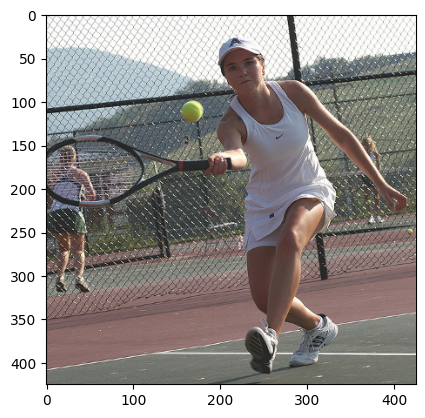

In [11]:
plt.imshow(image)

roi_name_maps[roi_name_ind]

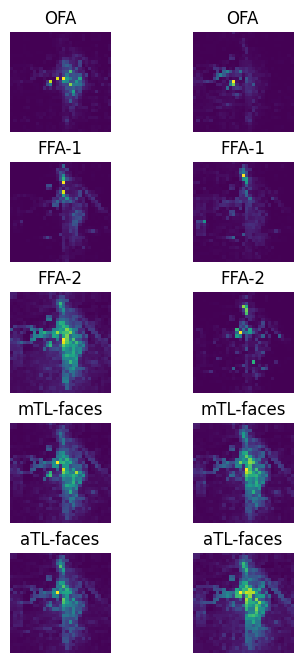

In [12]:
#plt.imshow(dec_attn_weights[0][1])
im_ind = 0

fig = plt.figure(figsize=(4.5, 2.29*(len(roi_name_maps[roi_name_ind])-1)))
# and we add one plot per reference point
gs = fig.add_gridspec(7, 2)
fig.subplots_adjust(wspace=0.1, hspace=0.3)

for i in range(2):
    for j in range(1,len(roi_name_maps[roi_name_ind])):
        ax = plt.subplot(gs[j-1,i])
        ax.imshow(dec_attn_weights[im_ind][(i*8) + j])
        plt.axis('off')
        ax.set_title(roi_name_maps[roi_name_ind][j])
        

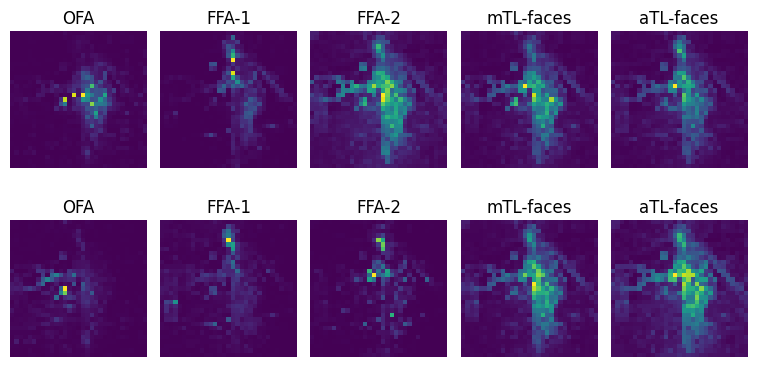

In [13]:
#plt.imshow(dec_attn_weights[0][1])
im_ind = 0

fig = plt.figure(figsize=(2.29*(len(roi_name_maps[roi_name_ind])-1), 4.5))
# and we add one plot per reference point
gs = fig.add_gridspec(2, len(roi_name_maps[roi_name_ind]))
fig.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(2):
    for j in range(1,len(roi_name_maps[roi_name_ind])):
        ax = plt.subplot(gs[i,j-1])
        ax.imshow(dec_attn_weights[im_ind][(i*8) + j])
        plt.axis('off')
        ax.set_title(roi_name_maps[roi_name_ind][j])
        
#fig.savefig("../figures/faces.png", bbox_inches='tight', dpi=300)